<a href="https://colab.research.google.com/github/ArchanGhosh/GAN-/blob/master/DC_GAN_for_FASHION_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

**Importing the necessary Libraries and Packages**

In [ ]:
import tensorflow as tf
import numpy as np
import imageio
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import os 
import PIL
import time
import pandas as pd

from keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose, Conv2D, Dropout, Flatten
from keras import Sequential
from IPython import display

%matplotlib inline

import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Importing the Fashion MNIST dataset from TFDS

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


Processing the data to fit the model

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5)/ 127.5

BUFFER_SIZE = 60000
BATCH_SIZE = 256

X_train = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Building the Model

In [ ]:
def build_generator():
  model = Sequential()
  model.add(Dense(7*7*256, use_bias = False, input_shape=(100,)))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256)

  model.add(Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh' ))
  assert model.output_shape ==(None, 28, 28, 1)

  return model

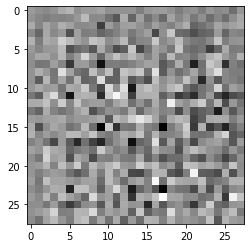

In [ ]:
gen = build_generator()

noise = tf.random.normal([1,100])
generated_image = gen(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
def build_discriminator():
  model = Sequential()
  model.add(Conv2D(64, (5, 5), strides=(2,2), padding='same', input_shape=[28,28,1]))

  model.add(LeakyReLU())
  model.add(Dropout(0.3))

  model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(LeakyReLU())
  model.add(Dropout(0.3))

  model.add(Flatten())
  model.add(Dense(1))

  return model

In [ ]:
def build_discriminator():
  model = Sequential()
  model.add(Conv2D(64, (5, 5), strides=(2,2), padding='same', input_shape=[28,28,1]))

  model.add(LeakyReLU())
  model.add(Dropout(0.3))

  model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(LeakyReLU())
  model.add(Dropout(0.3))

  model.add(Flatten())
  model.add(Dense(1))

  return model

In [ ]:
disc = build_discriminator()
decision = disc(generated_image)

print(decision)

tf.Tensor([[0.00215461]], shape=(1, 1), dtype=float32)


# Defining the Losses

In [ ]:
bce = keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
  real_loss = bce(tf.ones_like(real_output), real_output)
  fake_loss = bce(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss

  return total_loss

In [ ]:
def generator_loss(fake_output):
  return bce(tf.ones_like(fake_output), fake_output)

# Setting up the Optimizer

In [ ]:
gen_optimizer = keras.optimizers.Adam(1e-4)
dis_optimizer = keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = gen_optimizer,
                                 discriminator_optimizer=dis_optimizer,
                                 generator=gen,
                                 discriminator=disc)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = gen_optimizer,
                                 discriminator_optimizer=dis_optimizer,
                                 generator=gen,
                                 discriminator=disc)

**Setting the Hyper-parameters**

In [ ]:
epochs = 250

noise_dim = 100

to_gen = 16

seed = tf.random.normal([to_gen, noise_dim])

# Defining the training function

In [ ]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = gen(noise, training=True)

    real_output = disc(images, training=True)
    fake_output = disc(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    dis_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, gen.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(dis_loss, disc.trainable_variables)

    gen_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))
    dis_optimizer.apply_gradients(zip(gradients_of_discriminator, disc.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(gen, epoch +1, seed)

    if(epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_images(gen, epochs, seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

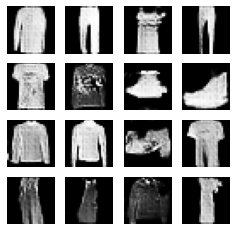

In [ ]:
train(X_train, epochs)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
from PIL import Image

frames = []
imgs = glob.glob("*.png")
imgs.sort()
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

In [ ]:
frames[0].save('training.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=100, loop=0)

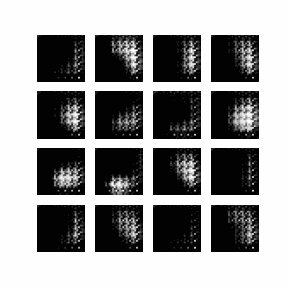

In [ ]:
from IPython.display import Image 
Image(open('training.gif','rb').read())

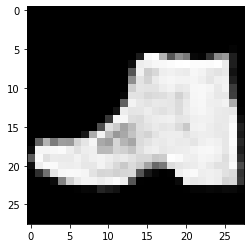

In [ ]:
img_gen = tf.random.normal([1,100])
generated_image = gen(img_gen, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')